The number of rows before dropping rows with NaNs : 76000
The number of rows after dropping rows with NaNs : 74600
[0]	validation_0-rmse:49.61567
[1]	validation_0-rmse:47.74417
[2]	validation_0-rmse:46.10110
[3]	validation_0-rmse:44.60836
[4]	validation_0-rmse:43.50282
[5]	validation_0-rmse:42.30978
[6]	validation_0-rmse:41.20408
[7]	validation_0-rmse:40.17507
[8]	validation_0-rmse:39.30623
[9]	validation_0-rmse:38.50240
[10]	validation_0-rmse:37.79317
[11]	validation_0-rmse:37.10940
[12]	validation_0-rmse:36.47729
[13]	validation_0-rmse:35.92855
[14]	validation_0-rmse:35.43325
[15]	validation_0-rmse:35.00629
[16]	validation_0-rmse:34.63699
[17]	validation_0-rmse:34.30827
[18]	validation_0-rmse:34.00031
[19]	validation_0-rmse:33.70929
[20]	validation_0-rmse:33.41702
[21]	validation_0-rmse:33.16047
[22]	validation_0-rmse:32.96016
[23]	validation_0-rmse:32.75150
[24]	validation_0-rmse:32.56992
[25]	validation_0-rmse:32.41159
[26]	validation_0-rmse:32.24848
[27]	validation_0-rmse:32.10275

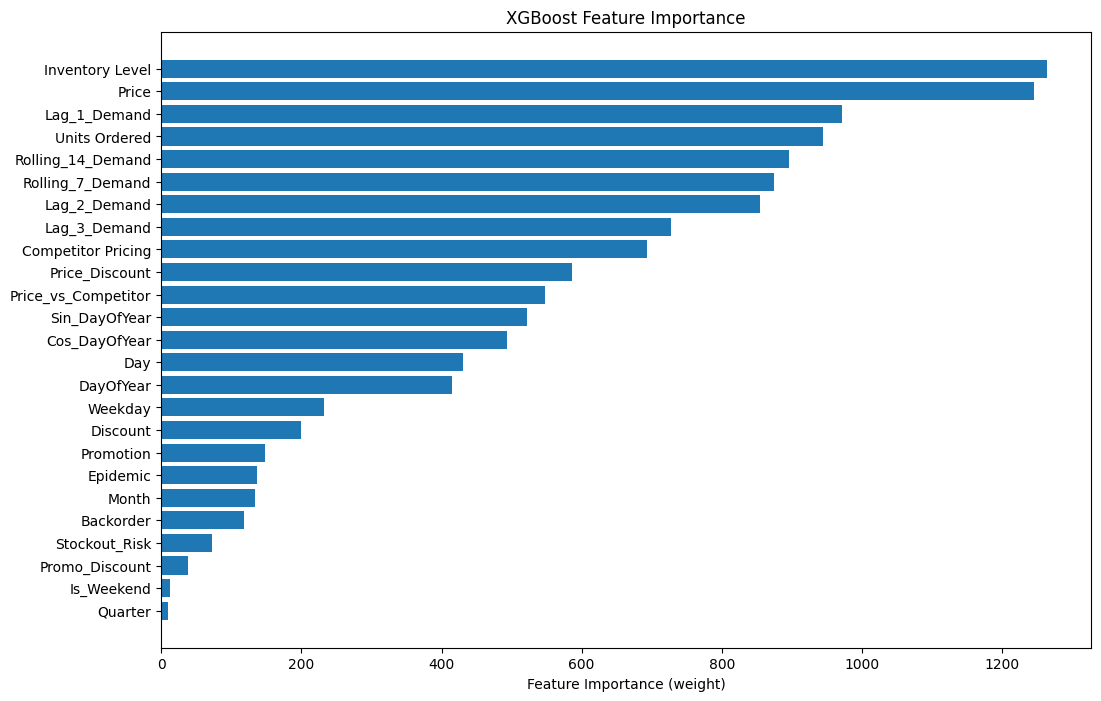

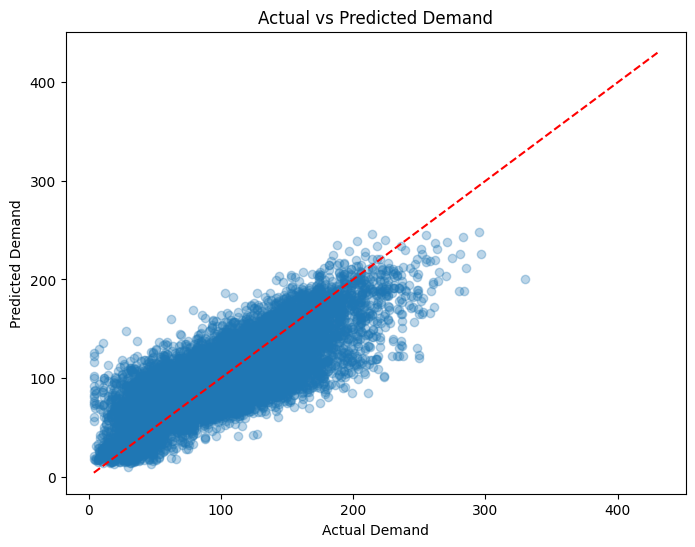

In [114]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("sales_data.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Create unique key for grouping
df['Store_Product_ID'] = df['Store ID'].astype(str) + '_' + df['Product ID'].astype(str)

# Sort by Store_Product_ID and Date for lag features
df = df.sort_values(['Store_Product_ID', 'Date'])

df['Lag_1_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(1)
df['Lag_2_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(2)
df['Lag_3_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(3)
df['Rolling_7_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(1).rolling(window=7).mean()
df['Rolling_14_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(1).rolling(window=14).mean()

# Date features
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['IsWeekend'] = df['Weekday'].isin([5, 6]).astype(int)

# === 6. Backorder and stockout risk ===
df['Backorder'] = (df['Units Ordered'] > df['Units Sold']).astype(int)
df['Stockout_Risk'] = (df['Inventory Level'] < df['Units Ordered']).astype(int)

# === 7. Date features + seasonality ===
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Quarter'] = df['Date'].dt.quarter
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Is_Weekend'] = df['Weekday'].isin([5, 6]).astype(int)
df['Sin_DayOfYear'] = np.sin(2 * np.pi * df['DayOfYear'] / 365)
df['Cos_DayOfYear'] = np.cos(2 * np.pi * df['DayOfYear'] / 365)

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['Region', 'Weather Condition', 'Seasonality'], drop_first=True)

# === 9. Feature interactions ===
df['Price_Discount'] = df['Price'] * df['Discount']
df['Price_vs_Competitor'] = df['Price'] - df['Competitor Pricing']
df['Promo_Discount'] = df['Promotion'] * df['Discount']

# === 10. Drop rows with NaNs ===
print(f"The number of rows before dropping rows with NaNs : {len(df)}")
df.dropna(inplace=True)
print(f"The number of rows after dropping rows with NaNs : {len(df)}")

# Define features and target
feature_cols = [
    'Price', 'Discount', 'Competitor Pricing', 'Promotion', 'Inventory Level',
    'Units Ordered', 'Month', 'Day', 'Weekday', 'Quarter', 'DayOfYear', 'Is_Weekend',
    'Sin_DayOfYear', 'Cos_DayOfYear', 'Backorder', 'Stockout_Risk', 'Epidemic',
    'Lag_1_Demand', 'Lag_2_Demand', 'Lag_3_Demand', 'Rolling_7_Demand', 'Rolling_14_Demand',
    'Price_Discount', 'Price_vs_Competitor', 'Promo_Discount'
]

X = df[feature_cols]
y = df['Demand']

# Keep Date for splitting only
dates = df['Date']

# Train/test split by date (80% train, 20% test)
split_date = dates.quantile(0.8)

X_train = X[dates <= split_date]
y_train = y[dates <= split_date]
X_test = X[dates > split_date]
y_test = y[dates > split_date]

dates_train = dates[dates <= split_date]

# Further split training into train/validation by date (80% train_sub, 20% val)
val_split_date = dates_train.quantile(0.8)

X_train_sub = X_train[dates_train <= val_split_date]
y_train_sub = y_train[dates_train <= val_split_date]

X_val = X_train[dates_train > val_split_date]
y_val = y_train[dates_train > val_split_date]

# Train XGBRegressor with early stopping
model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.08,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
)
# model = XGBRegressor(
#     n_estimators=800,
#     learning_rate=0.08,
#     max_depth=6,
#     random_state=42,
#     verbosity=1,
#     n_jobs=-1
# )

model.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


print(f"Early stopping model R² Score: {r2:.4f}")
print(f"Early stopping model RMSE: {rmse:.4f}")
print(f"Early stopping model MAE: {mae:.4f}")

# 1. Std dev of actual demand
actual_std = y_test.std()
print(f"Standard Deviation of Actual Demand: {actual_std:.4f}")

# 2. Std dev of residuals/errors
residuals = y_test - y_pred
residuals_std = residuals.std()
print(f"Standard Deviation of Residuals: {residuals_std:.4f}")

# Feature importance plot
plt.figure(figsize=(12, 8))
xgb_importance = model.get_booster().get_score(importance_type='weight')
xgb_importance = dict(sorted(xgb_importance.items(), key=lambda item: item[1], reverse=True))
plt.barh(list(xgb_importance.keys())[::-1], list(xgb_importance.values())[::-1])
plt.xlabel("Feature Importance (weight)")
plt.title("XGBoost Feature Importance")
plt.show()

# Actual vs Predicted plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Actual vs Predicted Demand")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()


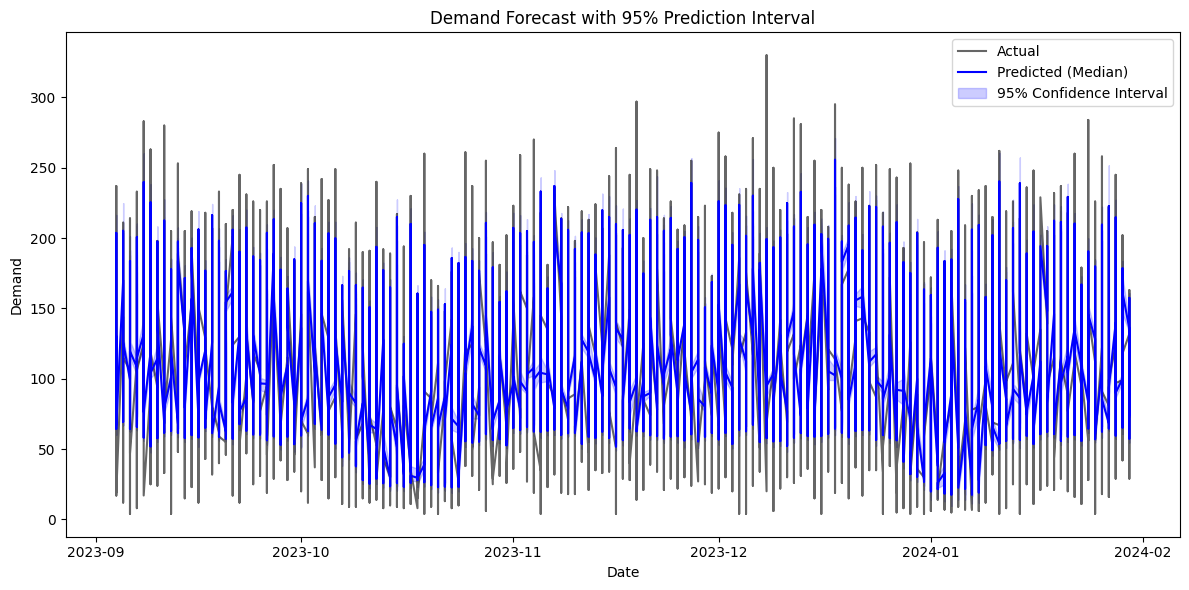

In [115]:
def quantile_loss(q, y_true, y_pred):
    error = y_true - y_pred
    return np.maximum(q * error, (q - 1) * error)

from sklearn.utils import resample

# Parameters
n_bootstraps = 20
quantiles = [0.025, 0.5, 0.975]  # 95% confidence interval (2.5% – 97.5%)

# Store all predictions
all_preds = []

for i in range(n_bootstraps):
    X_resampled, y_resampled = resample(X_train_sub, y_train_sub, random_state=42 + i)
    
    model_boot = XGBRegressor(
        n_estimators=model.best_iteration,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42 + i,
        n_jobs=-1
    )
    model_boot.fit(X_resampled, y_resampled)
    
    preds = model_boot.predict(X_test)
    all_preds.append(preds)

# Convert to array: shape = (n_models, n_samples)
all_preds = np.array(all_preds)

# Calculate prediction intervals
preds_lower = np.percentile(all_preds, 2.5, axis=0)
preds_median = np.percentile(all_preds, 50, axis=0)
preds_upper = np.percentile(all_preds, 97., axis=0)

import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
# plt.plot(y_test.values, label='Actual', color='black', alpha=0.6)
# plt.plot(preds_median, label='Predicted (Median)', color='blue')
# plt.plot(preds_lower, label='Lower Bound (2.5%)', linestyle='--', color='gray')
# plt.plot(preds_upper, label='Upper Bound (97.5%)', linestyle='--', color='gray')
# plt.axvline(x=len(y_test) // 2, color='red', linestyle=':', alpha=0.5)
# plt.fill_between(range(len(y_test)), preds_lower, preds_upper, color='blue', alpha=0.2, label='95% Confidence Interval')
# plt.xlabel("Test Sample Index")
# plt.ylabel("Demand")
# plt.title("Demand Forecast with 95% Prediction Interval")
# plt.legend()
# plt.tight_layout()
# plt.show()

# Build a DataFrame to sort predictions and actuals by Date
plot_df = pd.DataFrame({
    'Date': dates[dates > split_date],
    'Actual': y_test,
    'Predicted': preds_median,
    'Lower': preds_lower,
    'Upper': preds_upper
}).sort_values('Date').reset_index(drop=True)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(plot_df['Date'], plot_df['Actual'], label='Actual', color='black', alpha=0.6)
plt.plot(plot_df['Date'], plot_df['Predicted'], label='Predicted (Median)', color='blue')
plt.fill_between(plot_df['Date'], plot_df['Lower'], plot_df['Upper'], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Demand Forecast with 95% Prediction Interval")
plt.legend()
plt.tight_layout()
plt.show()

In [116]:
import pandas as pd

metrics_table = pd.DataFrame({
    'Metric': ['R²', 'RMSE', 'MAE'],
    'Value': [r2, rmse, mae]
})

print(metrics_table.to_string(index=False))


Metric     Value
    R²  0.634598
  RMSE 26.709173
   MAE 20.070875


In [117]:
# Set Holding & Shortage Cost Percentages

# Assume 2% monthly storage cost (or adjust as needed)
holding_rate = 0.02  # 2% of unit price per period

# Assume 25% of price is lost per unit short (e.g., profit margin)
shortage_rate = 0.25  # 25% of price

df['Holding Cost Per Unit'] = df['Price'] * holding_rate
df['Shortage Cost Per Unit'] = df['Price'] * shortage_rate

In [118]:
print(df[['Store_Product_ID', 'Price', 'Holding Cost Per Unit', 'Shortage Cost Per Unit']].head())


     Store_Product_ID  Price  Holding Cost Per Unit  Shortage Cost Per Unit
1400       S001_P0001  81.93                 1.6386                 20.4825
1500       S001_P0001  71.17                 1.4234                 17.7925
1600       S001_P0001  61.85                 1.2370                 15.4625
1700       S001_P0001  69.63                 1.3926                 17.4075
1800       S001_P0001  70.59                 1.4118                 17.6475


In [119]:
# Compute Surplus and Shortage Quantities

# Units over demand = surplus → used for holding cost
df['Surplus Units'] = (df['Inventory Level'] - df['Demand']).clip(lower=0)

# Units below demand = shortage → used for shortage cost
df['Shortage Units'] = (df['Demand'] - df['Inventory Level']).clip(lower=0)


In [120]:
# Calculate Holding and Shortage Costs

df['Holding Cost'] = df['Surplus Units'] * df['Holding Cost Per Unit']
df['Shortage Cost'] = df['Shortage Units'] * df['Shortage Cost Per Unit']
df['Total Cost'] = df['Holding Cost'] + df['Shortage Cost']


In [121]:
print(df[['Date', 'Store_Product_ID', 'Inventory Level', 'Demand',
          'Surplus Units', 'Shortage Units',
          'Holding Cost', 'Shortage Cost', 'Total Cost']].head())


           Date Store_Product_ID  Inventory Level  Demand  Surplus Units  \
1400 2022-01-15       S001_P0001              180     175              5   
1500 2022-01-16       S001_P0001               54     126              0   
1600 2022-01-17       S001_P0001              287     102            185   
1700 2022-01-18       S001_P0001              512     102            410   
1800 2022-01-19       S001_P0001              411     123            288   

      Shortage Units  Holding Cost  Shortage Cost  Total Cost  
1400               0        8.1930           0.00      8.1930  
1500              72        0.0000        1281.06   1281.0600  
1600               0      228.8450           0.00    228.8450  
1700               0      570.9660           0.00    570.9660  
1800               0      406.5984           0.00    406.5984  


                  Holding Cost  Shortage Cost   Total Cost
Store_Product_ID                                          
S003_P0015         604029.5918     95018.0400  699047.6318
S002_P0014         599900.9386     58776.8825  658677.8211
S003_P0018         583042.3856     31288.8450  614331.2306
S005_P0012         547458.7592     30101.2725  577560.0317
S002_P0005         530541.6760     20077.8625  550619.5385


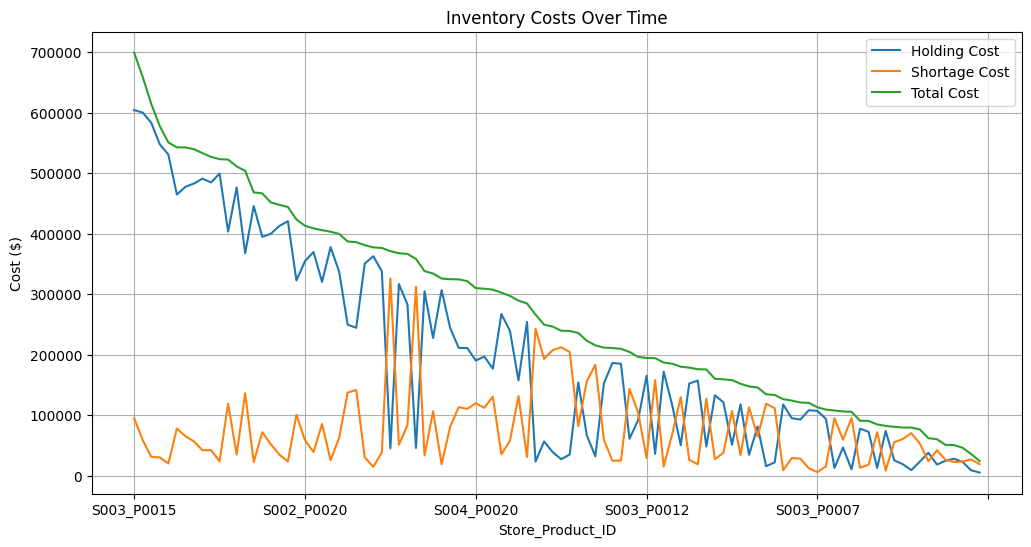

In [122]:
# Group by Store_Product_ID

cost_by_product = df.groupby('Store_Product_ID')[['Holding Cost', 'Shortage Cost', 'Total Cost']].sum().sort_values('Total Cost', ascending=False)

print(cost_by_product.head())

cost_by_product.plot(figsize=(12,6), title='Inventory Costs Over Time')
plt.ylabel('Cost ($)')
plt.grid(True)
plt.show()


In [123]:
# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Daily trend
cost_by_date = df.groupby('Date')[['Holding Cost', 'Shortage Cost', 'Total Cost']].sum()

# Optional: Monthly trend
df['Month'] = df['Date'].dt.to_period('M')
cost_by_month = df.groupby('Month')[['Holding Cost', 'Shortage Cost', 'Total Cost']].sum()

print(cost_by_month.tail())

         Holding Cost  Shortage Cost    Total Cost
Month                                             
2023-09   817310.6238    277407.1100  1.094718e+06
2023-10   722671.2996    215964.7975  9.386361e+05
2023-11   786097.0238    301757.5050  1.087855e+06
2023-12   883841.7874    335137.2425  1.218979e+06
2024-01   749789.6852    309493.7475  1.059283e+06


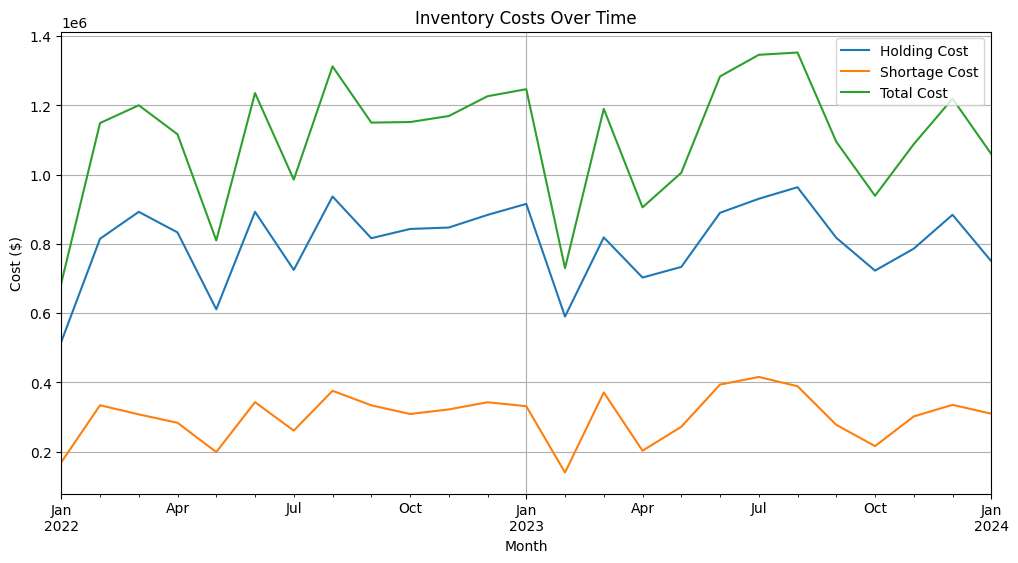

In [124]:
import matplotlib.pyplot as plt

# Plot total cost over time
cost_by_month.plot(figsize=(12,6), title='Inventory Costs Over Time')
plt.ylabel('Cost ($)')
plt.grid(True)
plt.show()

In [125]:
cost_by_store = df.groupby('Store ID')[['Holding Cost', 'Shortage Cost', 'Total Cost']].sum().sort_values('Total Cost', ascending=False)

print(cost_by_store.head())

          Holding Cost  Shortage Cost    Total Cost
Store ID                                           
S003      4.623293e+06   1.633134e+06  6.256428e+06
S002      4.673340e+06   1.518118e+06  6.191459e+06
S001      3.621262e+06   1.500964e+06  5.122226e+06
S004      3.482154e+06   1.615847e+06  5.098001e+06
S005      3.713650e+06   1.265611e+06  4.979261e+06


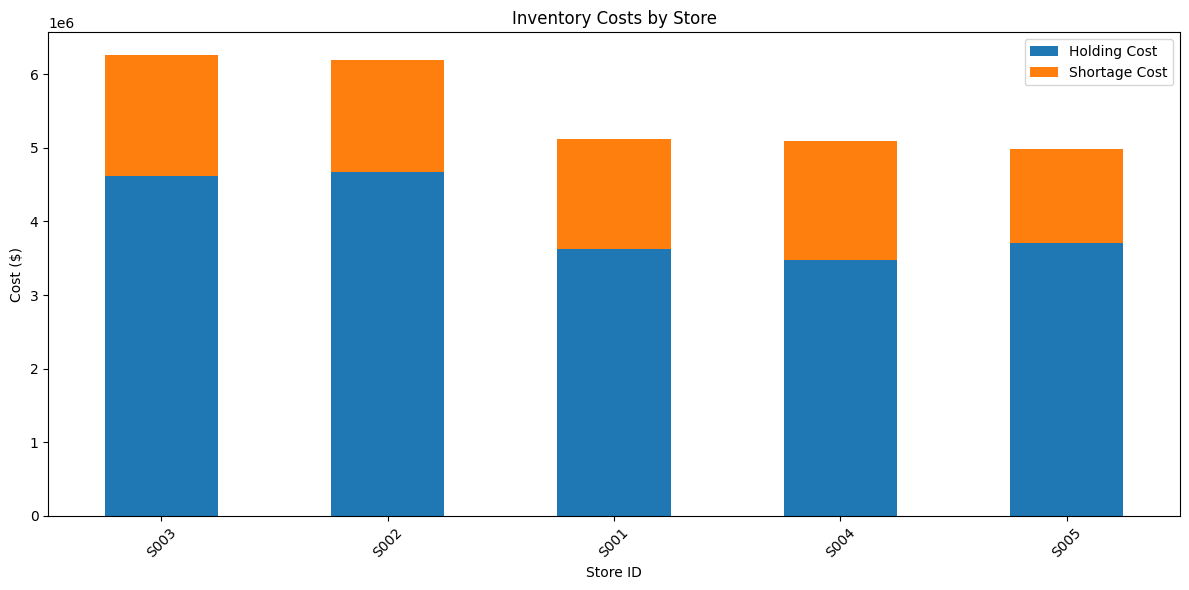

In [126]:
import matplotlib.pyplot as plt

cost_by_store[['Holding Cost', 'Shortage Cost']].plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Inventory Costs by Store')
plt.ylabel('Cost ($)')
plt.xlabel('Store ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [127]:
from scipy.stats import norm

target_service_level = 0.95

# z-score for target service level
z = norm.ppf(target_service_level)

In [128]:
# Assuming you have these columns:
# 'Units Sold' = actual demand observed
# 'Demand' = forecasted demand (Ridge Regression predictions)

# Calculate forecast errors
df['Forecast Error'] = df['Units Sold'] - df['Demand']

# Calculate standard deviation of forecast error per product or store_product_id
forecast_error_sd = df.groupby('Store_Product_ID')['Forecast Error'].std().rename('Forecast_Error_SD')

# Join back to your main dataframe (or a separate dataframe for forecasting)
df = df.merge(forecast_error_sd, on='Store_Product_ID', how='left')

# Optional: fill missing std dev with some small number if needed
df['Forecast_Error_SD'] = df['Forecast_Error_SD'].fillna(0)

# print(df[['Store_Product_ID', 'Forecast Error', 'Forecast_Error_SD']].head())
print(df['Forecast_Error_SD'].isna().sum())

0


In [129]:
# Calculate safety stock
df['Safety Stock'] = z * df['Forecast_Error_SD']

# Calculate optimal inventory
df['Optimal Inventory'] = df['Demand'] + df['Safety Stock']

# If you want to round up to nearest integer
df['Optimal Inventory'] = df['Optimal Inventory'].apply(np.ceil)

# Preview
print(df[['Store_Product_ID', 'Demand', 'Forecast_Error_SD', 'Safety Stock', 'Optimal Inventory']].head())

  Store_Product_ID  Demand  Forecast_Error_SD  Safety Stock  Optimal Inventory
0       S001_P0001     175          18.807347     30.935333              206.0
1       S001_P0001     126          18.807347     30.935333              157.0
2       S001_P0001     102          18.807347     30.935333              133.0
3       S001_P0001     102          18.807347     30.935333              133.0
4       S001_P0001     123          18.807347     30.935333              154.0


In [130]:
from scipy.stats import norm

service_levels = [0.90, 0.95, 0.99]
z_scores = [norm.ppf(sl) for sl in service_levels]

results = []

for sl, z in zip(service_levels, z_scores):
    df[f'Safety Stock {int(sl*100)}%'] = z * df['Forecast_Error_SD']
    df[f'Optimal Inventory {int(sl*100)}%'] = df['Demand'] + df[f'Safety Stock {int(sl*100)}%']
    df[f'Optimal Inventory {int(sl*100)}%'] = df[f'Optimal Inventory {int(sl*100)}%'].apply(np.ceil)
    
    # Calculate surplus, shortage, and costs
    surplus = (df[f'Optimal Inventory {int(sl*100)}%'] - df['Demand']).clip(lower=0)
    shortage = (df['Demand'] - df[f'Optimal Inventory {int(sl*100)}%']).clip(lower=0)
    
    holding_cost = surplus * df['Holding Cost Per Unit']
    shortage_cost = shortage * df['Shortage Cost Per Unit']
    total_cost = holding_cost + shortage_cost
    
    # Save summary stats for this service level
    summary = {
        'Service Level': sl,
        'Average Safety Stock': df[f'Safety Stock {int(sl*100)}%'].mean(),
        'Average Optimal Inventory': df[f'Optimal Inventory {int(sl*100)}%'].mean(),
        'Total Holding Cost': holding_cost.sum(),
        'Total Shortage Cost': shortage_cost.sum(),
        'Total Cost': total_cost.sum()
    }
    results.append(summary)


In [131]:
results_df = pd.DataFrame(results)
print(results_df)

   Service Level  Average Safety Stock  Average Optimal Inventory  \
0           0.90             32.311552                 136.991153   
1           0.95             41.471428                 146.121153   
2           0.99             58.653833                 163.311153   

   Total Holding Cost  Total Shortage Cost    Total Cost  
0        3.107405e+06                  0.0  3.107405e+06  
1        3.972754e+06                  0.0  3.972754e+06  
2        5.594813e+06                  0.0  5.594813e+06  


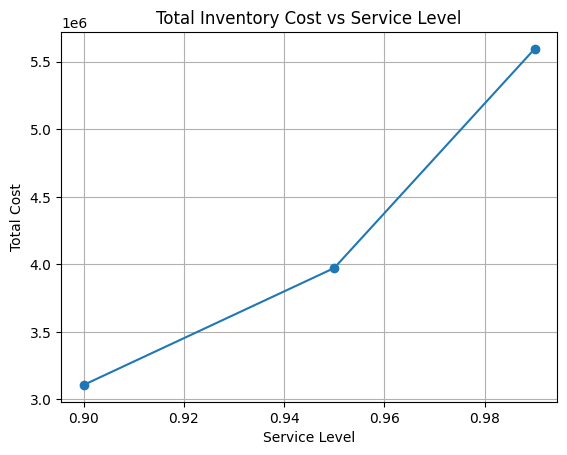

In [132]:
import matplotlib.pyplot as plt

plt.plot(results_df['Service Level'], results_df['Total Cost'], marker='o')
plt.title('Total Inventory Cost vs Service Level')
plt.xlabel('Service Level')
plt.ylabel('Total Cost')
plt.grid(True)
plt.show()


In [151]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Example service levels to simulate
service_levels = [0.90, 0.95, 0.99]
z_scores = [norm.ppf(sl) for sl in service_levels]

# Prepare a DataFrame to collect results per Store_Product_ID and service level
all_results = []

for sl, z in zip(service_levels, z_scores):
    suffix = str(int(sl * 100))
    safety_stock_col = f'Safety_Stock_{suffix}'
    optimal_inv_col = f'Optimal_Inventory_{suffix}'
    holding_cost_col = f'Holding_Cost_{suffix}'
    shortage_cost_col = f'Shortage_Cost_{suffix}'
    total_cost_col = f'Total_Cost_{suffix}'

    # Calculate safety stock
    df[safety_stock_col] = z * df['Forecast_Error_SD']
    if df[safety_stock_col].isna().any():
        print(f'NaNs found in {safety_stock_col}')
        print(df.loc[df[safety_stock_col].isna(), ['Store_Product_ID', safety_stock_col]])

    # Calculate optimal inventory
    df[optimal_inv_col] = np.ceil(df['Demand'] + df[safety_stock_col])
    if df[optimal_inv_col].isna().any():
        print(f'NaNs found in {optimal_inv_col}')
        print(df.loc[df[optimal_inv_col].isna(), ['Store_Product_ID', optimal_inv_col, 'Demand', safety_stock_col]])

    # Calculate surplus and shortage
    surplus = (df[optimal_inv_col] - df['Demand']).clip(lower=0)
    shortage = (df['Demand'] - df[optimal_inv_col]).clip(lower=0)

    # Calculate holding cost
    df[holding_cost_col] = surplus * df['Holding Cost Per Unit']
    if df[holding_cost_col].isna().any():
        print(f'NaNs found in {holding_cost_col}')
        print(df.loc[df[holding_cost_col].isna(), ['Store_Product_ID', holding_cost_col, 'Holding Cost Per Unit', 'Demand']])

    # Calculate shortage cost
    df[shortage_cost_col] = shortage * df['Shortage Cost Per Unit']
    if df[shortage_cost_col].isna().any():
        print(f'NaNs found in {shortage_cost_col}')
        print(df.loc[df[shortage_cost_col].isna(), ['Store_Product_ID', shortage_cost_col, 'Shortage Cost Per Unit', 'Demand']])

    # Calculate total cost
    df[total_cost_col] = df[holding_cost_col] + df[shortage_cost_col]
    if df[total_cost_col].isna().any():
        print(f'NaNs found in {total_cost_col}')
        print(df.loc[df[total_cost_col].isna(), ['Store_Product_ID', total_cost_col, holding_cost_col, shortage_cost_col]])

    # # Aggregate results by Store_Product_ID
    # grouped = df.groupby('Store_Product_ID')[
    #     [holding_cost_col, shortage_cost_col, total_cost_col, optimal_inv_col, safety_stock_col]
    # ].mean()
    # grouped = grouped.reset_index()
    # grouped['Service Level'] = sl

    # all_results.append(grouped)
    grouped = df.groupby('Store_Product_ID')[
        [holding_cost_col, shortage_cost_col, total_cost_col, optimal_inv_col, safety_stock_col]
    ].mean().reset_index()

    # Rename columns to common names
    grouped = grouped.rename(columns={
        holding_cost_col: 'Holding_Cost',
        shortage_cost_col: 'Shortage_Cost',
        total_cost_col: 'Total_Cost',
        optimal_inv_col: 'Optimal_Inventory',
        safety_stock_col: 'Safety_Stock'
    })

    grouped['Service_Level'] = sl

    all_results.append(grouped)

# Combine all service levels into one DataFrame
# results_df = pd.concat(all_results)
results_df = pd.concat(all_results, ignore_index=True)

# Preview results for a few Store_Product_IDs
# print(results_df.head(10))
print(results_df['Service_Level'].unique())


[0.9  0.95 0.99]


In [155]:
print(results_df.columns)

Index(['Store_Product_ID', 'Holding_Cost', 'Shortage_Cost', 'Total_Cost',
       'Optimal_Inventory', 'Safety_Stock', 'Service_Level'],
      dtype='object')


/tmp/ipykernel_567/2757612711.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


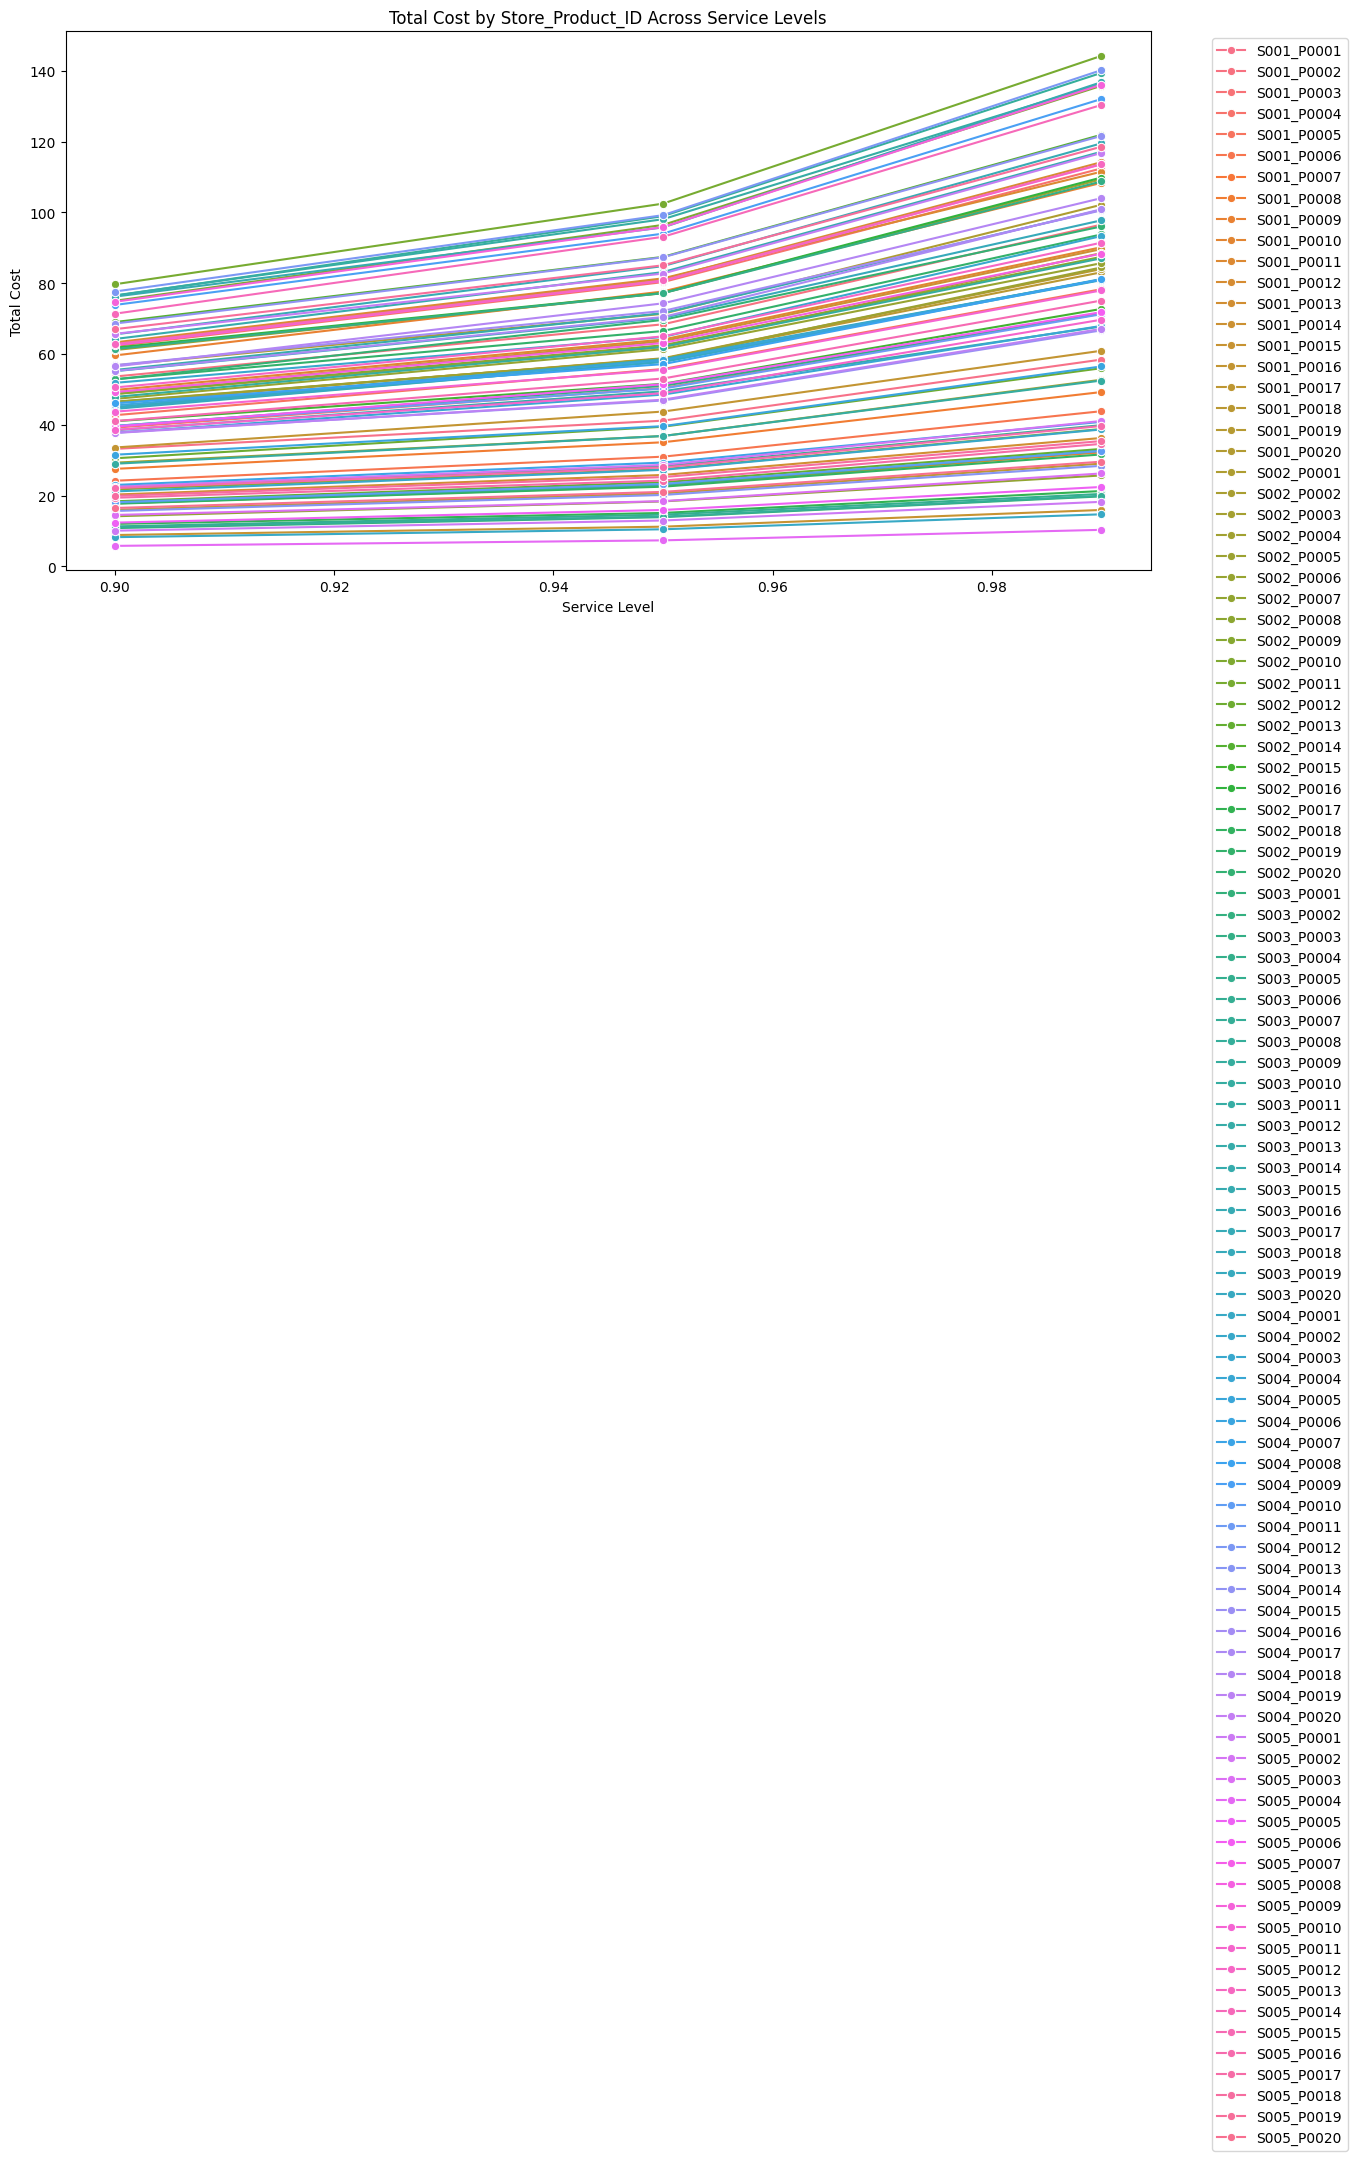

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))

sns.lineplot(
    data=results_df,
    x='Service_Level',          # ✅ Correct column name
    y='Total_Cost',             # ✅ Also correct after renaming
    hue='Store_Product_ID',
    marker='o'
)

plt.title('Total Cost by Store_Product_ID Across Service Levels')
plt.ylabel('Total Cost')
plt.xlabel('Service Level')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
